In [37]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score


In [38]:
dataset_files = [
    "S07-hw-dataset-01.csv",
    "S07-hw-dataset-02.csv",
    "S07-hw-dataset-03.csv",
    "S07-hw-dataset-04.csv"
]

datasets = {}
X_dict = {}
sample_ids = {}

for file in dataset_files:
    print(f"\n{'='*60}")
    print(f"Анализ файла: {file}")
    print('='*60)
    
    df = pd.read_csv(os.path.join("data", file))
    datasets[file] = df
    
    print("\n--- head() ---")
    print(df.head())
    
    print("\n--- info() ---")
    print(df.info())
    
    print("\n--- describe() ---")
    print(df.describe(include='all'))
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    print("\n--- Пропуски (кол-во / %) ---")
    missing_report = pd.DataFrame({
        'missing_count': missing,
        'missing_%': missing_pct.round(2)
    })
    print(missing_report[missing_report['missing_count'] > 0] if missing_report['missing_count'].any() else "Нет пропусков.")
    
    # Типы признаков
    print("\n--- Типы признаков ---")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    
    # Исключаем sample_id из признаков
    if 'sample_id' in numeric_cols:
        numeric_cols.remove('sample_id')
    if 'sample_id' in categorical_cols:
        categorical_cols.remove('sample_id')
    
    print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols}")
    print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols if categorical_cols else '-'}")
    
    # Сохраняем sample_id отдельно
    sample_id = df['sample_id'].copy()
    sample_ids[file] = sample_id
    
    # X - все столбцы, кроме sample_id
    X = df.drop(columns=['sample_id'])
    X_dict[file] = X
    
    print(f"\nФорма X: {X.shape}")


Анализ файла: S07-hw-dataset-01.csv

--- head() ---
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

--- info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        1200

In [39]:
# Словари для хранения препроцессоров и обработанных данных
preprocessors = {}
X_processed = {}

for file in dataset_files:
    print(f"\n{'='*60}")
    print(f"Препроцессинг: {file}")
    print('='*60)
    
    X = X_dict[file].copy()
    
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
    print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features if categorical_features else '-'}")
    
    has_numeric_missing = X[numeric_features].isnull().any().any() if numeric_features else False
    print(f"Пропуски в числовых признаках: {'Да' if has_numeric_missing else 'Нет'}")
    
    # Строим трансформер
    transformers = []
    
    if numeric_features:
        # Для числовых: импутация + масштабирование
        num_pipe = SimpleImputer(strategy='median')
        num_pipe = StandardScaler()

        num_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', num_pipe, numeric_features))
    
    if categorical_features:
        # Для категориальных: OneHotEncoding
        cat_pipe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        transformers.append(('cat', cat_pipe, categorical_features))
    
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )
    
    X_trans = preprocessor.fit_transform(X)
    print(f"Форма после препроцессинга: {X_trans.shape}")
    
    preprocessors[file] = preprocessor
    X_processed[file] = X_trans


Препроцессинг: S07-hw-dataset-01.csv
Числовые признаки (8): ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']
Категориальные признаки (0): -
Пропуски в числовых признаках: Нет
Форма после препроцессинга: (12000, 8)

Препроцессинг: S07-hw-dataset-02.csv
Числовые признаки (3): ['x1', 'x2', 'z_noise']
Категориальные признаки (0): -
Пропуски в числовых признаках: Нет
Форма после препроцессинга: (8000, 3)

Препроцессинг: S07-hw-dataset-03.csv
Числовые признаки (4): ['x1', 'x2', 'f_corr', 'f_noise']
Категориальные признаки (0): -
Пропуски в числовых признаках: Нет
Форма после препроцессинга: (15000, 4)

Препроцессинг: S07-hw-dataset-04.csv
Числовые признаки (30): ['n01', 'n02', 'n03', 'n04', 'n05', 'n06', 'n07', 'n08', 'n09', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30']
Категориальные признаки (2): ['cat_a', 'cat_b']
Пропуски в числовых признаках: Да
Форма после препроцессинга: (1000


Моделирование: S07-hw-dataset-01.csv
Размер данных после препроцессинга: (12000, 8)

- Запуск KMeans...


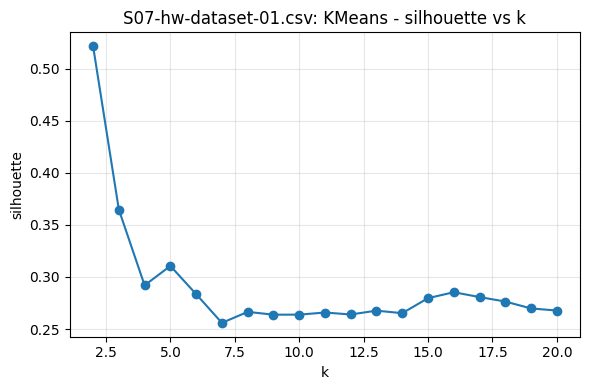


- Запуск DBSCAN...
- Лучший DBSCAN: eps=2.0, min_samples=3, silhouette=0.522, noise_frac=0.000

Моделирование: S07-hw-dataset-02.csv
Размер данных после препроцессинга: (8000, 3)

- Запуск KMeans...


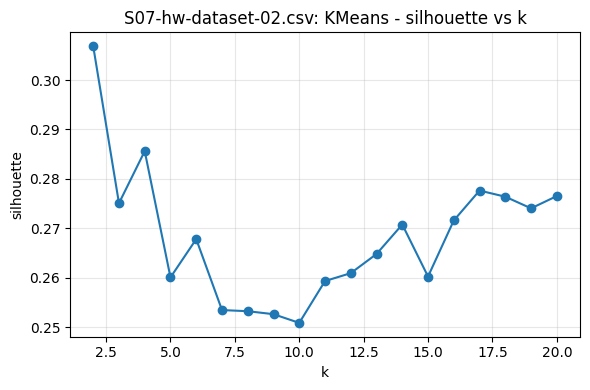


- Запуск DBSCAN...
- Лучший DBSCAN: eps=0.7, min_samples=15, silhouette=0.349, noise_frac=0.051

Моделирование: S07-hw-dataset-03.csv
Размер данных после препроцессинга: (15000, 4)

- Запуск KMeans...


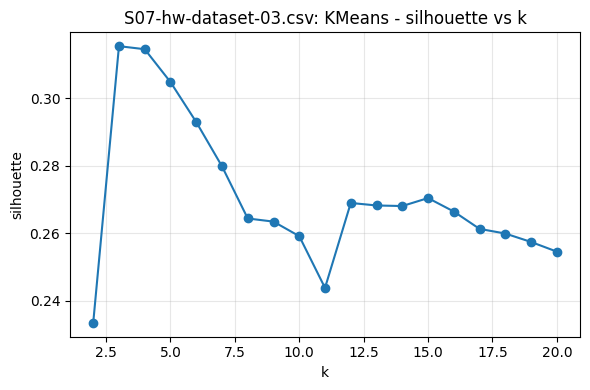


- Запуск DBSCAN...
- Лучший DBSCAN: eps=0.3, min_samples=15, silhouette=0.269, noise_frac=0.299

Моделирование: S07-hw-dataset-04.csv
Размер данных после препроцессинга: (10000, 42)

- Запуск KMeans...


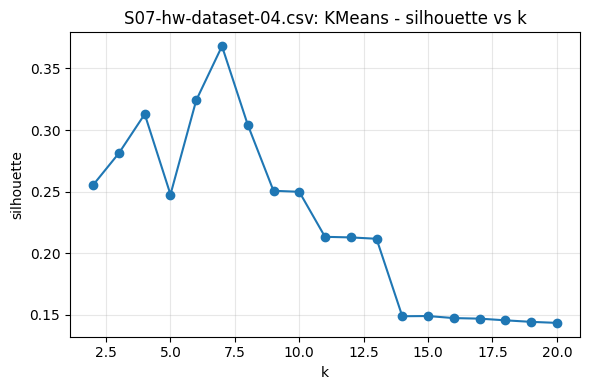


- Запуск DBSCAN...
- Лучший DBSCAN: eps=2.0, min_samples=10, silhouette=0.507, noise_frac=0.488


In [40]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

K_RANGE = list(range(2, 21))
EPS_LIST = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0]
MIN_SAMPLES_LIST = [3, 5, 8, 10, 15]

results = {}

def safe_cluster_metrics(X, labels):
    """Безопасный расчёт внутренних метрик."""
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    

    if n_clusters < 2:
        return None
    
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None
    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None
    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None
        
    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

for file in dataset_files:
    print(f"\n{'='*60}")
    print(f"Моделирование: {file}")
    print('='*60)
    
    X = X_processed[file]
    n_samples = X.shape[0]
    print(f"Размер данных после препроцессинга: {X.shape}")
    
    file_results = {
        "kmeans": [],
        "dbscan": []
    }
    
    # ---------- KMeans ----------
    print("\n- Запуск KMeans...")
    sil_scores = []
    ks = []
    
    for k in K_RANGE:
        try:
            kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(X)
        metrics = safe_cluster_metrics(X, labels)
        
        file_results["kmeans"].append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels.copy(),
            "metrics": metrics,
            "inertia": float(kmeans.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0
        })
        
        if metrics and metrics["silhouette"] is not None:
            sil_scores.append(metrics["silhouette"])
            ks.append(k)
        else:
            sil_scores.append(np.nan)
            ks.append(k)
    

    plt.figure(figsize=(6, 4))
    plt.plot(ks, sil_scores, marker="o")
    plt.title(f"{file}: KMeans - silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # ---------- DBSCAN ----------
    print("\n- Запуск DBSCAN...")
    for eps in EPS_LIST:
        for min_samples in MIN_SAMPLES_LIST:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            noise_mask = (labels == -1)
            noise_frac = np.mean(noise_mask)
            
            # Метрики считаем только по non-noise точкам

            if noise_frac < 1.0:
                X_nn = X[~noise_mask]
                labels_nn = labels[~noise_mask]
                uniq = np.unique(labels_nn)
                if len(uniq) >= 2:
                    mapping = {u: i for i, u in enumerate(uniq)}
                    labels_nn_renum = np.array([mapping[l] for l in labels_nn])
                    metrics = safe_cluster_metrics(X_nn, labels_nn_renum)
                else:
                    metrics = None
                n_clusters = len(uniq)
            else:
                metrics = None
                n_clusters = 0
            
            file_results["dbscan"].append({
                "algo": "dbscan",
                "params": {"eps": eps, "min_samples": min_samples},
                "labels": labels.copy(),
                "metrics": metrics,
                "inertia": None,
                "n_clusters": n_clusters,
                "noise_frac": float(noise_frac)
            })
    valid_dbscan = [r for r in file_results["dbscan"] if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
    if valid_dbscan:
        best_db = max(valid_dbscan, key=lambda r: r["metrics"]["silhouette"])
        print(f"- Лучший DBSCAN: eps={best_db['params']['eps']}, min_samples={best_db['params']['min_samples']}, "
          f"silhouette={best_db['metrics']['silhouette']:.3f}, noise_frac={best_db['noise_frac']:.3f}")
    else:
        print("- Нет валидных DBSCAN-конфигураций с ≥2 кластерами.")
    
    results[file] = file_results


Визуализация: S07-hw-dataset-01.csv
- Лучший алгоритм: kmeans, параметры: {'k': 2}
- Silhouette: 0.522


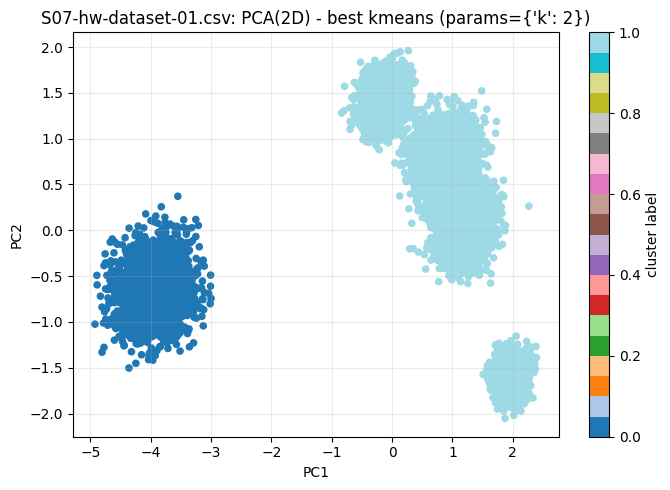

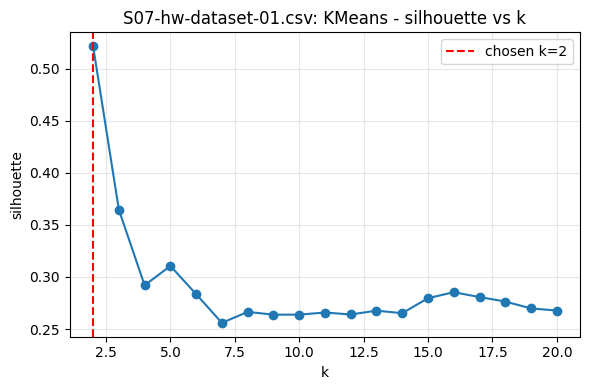


Визуализация: S07-hw-dataset-02.csv
- Лучший алгоритм: dbscan, параметры: {'eps': 0.7, 'min_samples': 15}
- Silhouette: 0.349
- Доля шума: 0.051


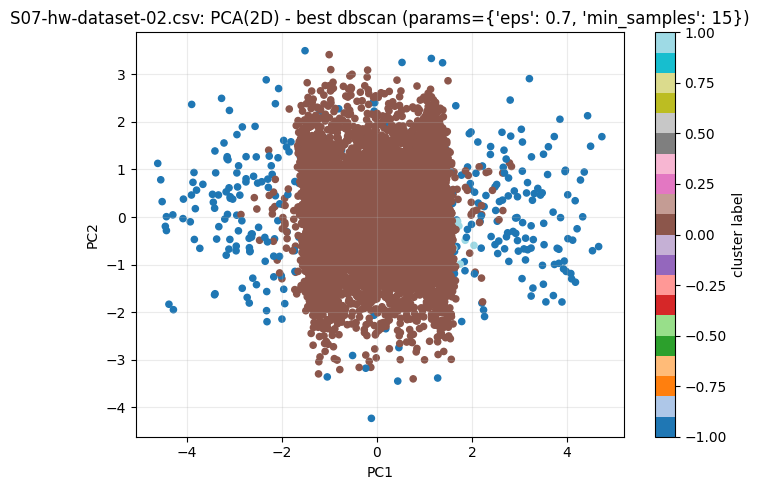

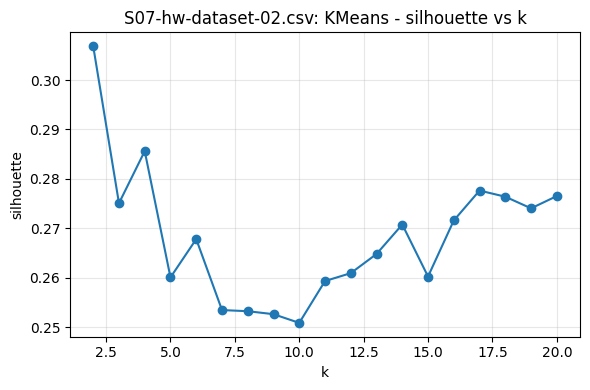


Визуализация: S07-hw-dataset-03.csv
- Лучший алгоритм: kmeans, параметры: {'k': 3}
- Silhouette: 0.316


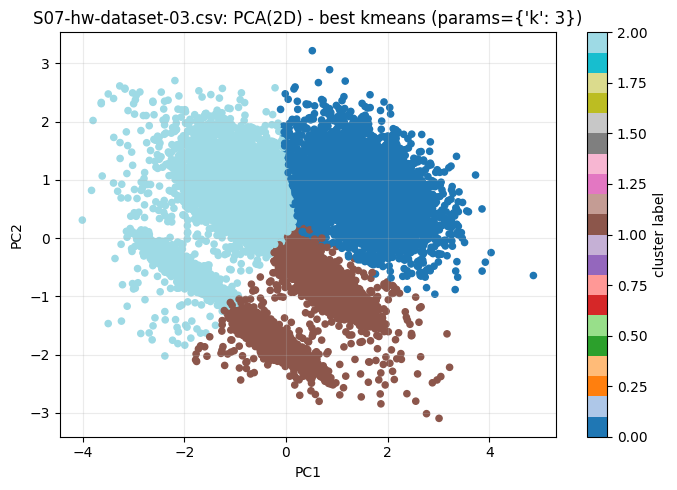

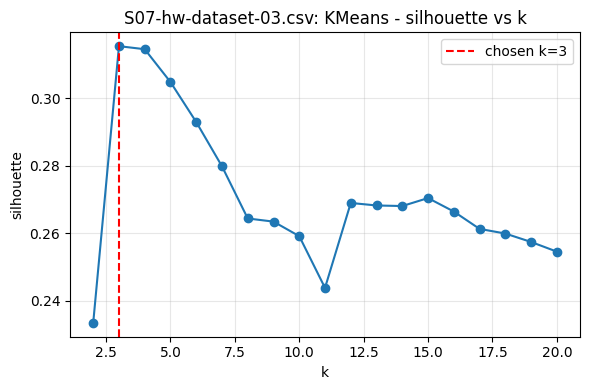


Визуализация: S07-hw-dataset-04.csv
- Лучший алгоритм: dbscan, параметры: {'eps': 2.0, 'min_samples': 10}
- Silhouette: 0.507
- Доля шума: 0.488


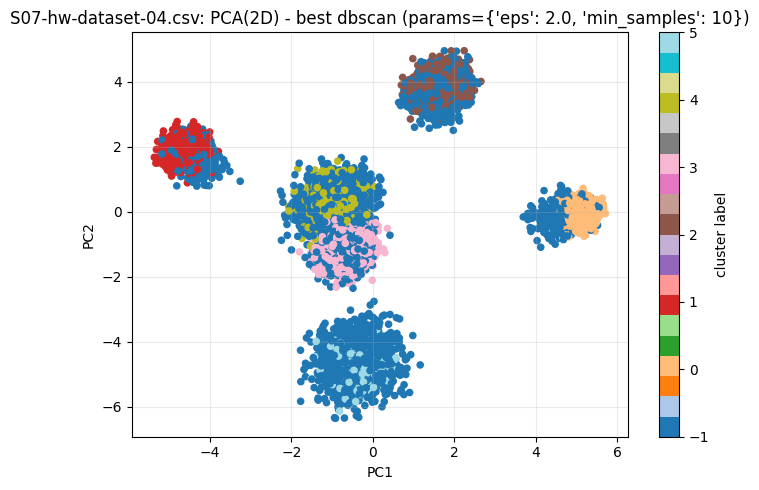

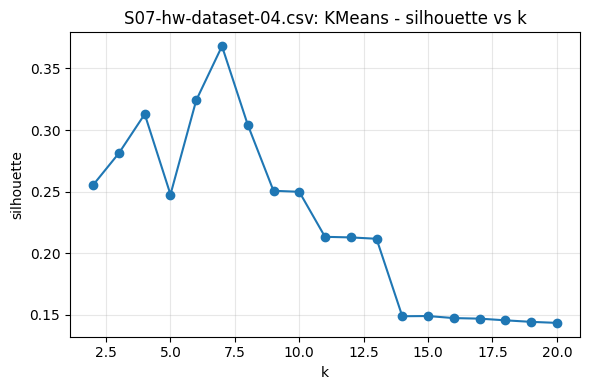

In [41]:
figures_dir = "artifacts/figures"
os.makedirs(figures_dir, exist_ok=True)

def select_best_by_silhouette(results_list):
    best = None
    best_score = -np.inf
    for r in results_list:
        m = r["metrics"]
        if m is None or m["silhouette"] is None:
            continue
        if m["silhouette"] > best_score:
            best_score = m["silhouette"]
            best = r
    return best

best_solutions = {}

# --- Основной цикл по датасетам ---
for file in dataset_files:
    print(f"\n{'='*60}")
    print(f"Визуализация: {file}")
    print('='*60)
    
    X = X_processed[file]
    all_runs = results[file]["kmeans"] + results[file]["dbscan"]
    
    best = select_best_by_silhouette(all_runs)
    if best is None:
        print("Нет валидных решений с silhouette.")
        continue
    
    best_solutions[file] = best

    labels = best["labels"]
    algo = best["algo"]
    params = best["params"]
    noise_frac = best.get("noise_frac", 0.0)
    
    print(f"- Лучший алгоритм: {algo}, параметры: {params}")
    print(f"- Silhouette: {best['metrics']['silhouette']:.3f}")
    if algo == "dbscan":
        print(f"- Доля шума: {noise_frac:.3f}")
    
    # ---------- PCA(2D) ----------
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=20, cmap='tab20')
    plt.title(f"{file}: PCA(2D) - best {algo} (params={params})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.25)
    plt.colorbar(scatter, label="cluster label")
    plt.tight_layout()
    fig_path = os.path.join(figures_dir, f"pca2d_{file.replace('.csv', '')}.png")
    plt.savefig(fig_path, dpi=150)
    plt.show()
    
    # ---------- График silhouette vs k для KMeans ----------
    kmeans_runs = [r for r in all_runs if r["algo"] == "kmeans"]
    if kmeans_runs:
        ks = [r["params"]["k"] for r in kmeans_runs]
        sil_scores = [
            r["metrics"]["silhouette"] if r["metrics"] and r["metrics"]["silhouette"] is not None else np.nan
            for r in kmeans_runs
        ]
        
        plt.figure(figsize=(6, 4))
        plt.plot(ks, sil_scores, marker="o")
        # Отмечается выбранное k, если лучшая модель - KMeans
        if algo == "kmeans":
            plt.axvline(x=params["k"], color='red', linestyle='--', label=f'chosen k={params["k"]}')
            plt.legend()
        plt.title(f"{file}: KMeans - silhouette vs k")
        plt.xlabel("k")
        plt.ylabel("silhouette")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        fig_path = os.path.join(figures_dir, f"silhouette_vs_k_{file.replace('.csv', '')}.png")
        plt.savefig(fig_path, dpi=150)
        plt.show()
    else:
        print("- Нет KMeans-запусков для графика silhouette vs k.")

In [42]:
file = "S07-hw-dataset-02.csv"
X = X_processed[file]

all_runs = results[file]["kmeans"] + results[file]["dbscan"]
best_kmeans_run = None
best_sil = -np.inf
for r in all_runs:
    if r["algo"] == "kmeans" and r["metrics"] is not None and r["metrics"]["silhouette"] is not None:
        if r["metrics"]["silhouette"] > best_sil:
            best_sil = r["metrics"]["silhouette"]
            best_kmeans_run = r

if best_kmeans_run is None:
    # fallback: выбираем k=2..20 с максимальным silhouette среди KMeans
    kmeans_runs = [r for r in results[file]["kmeans"] if r["metrics"] and r["metrics"]["silhouette"] is not None]
    if kmeans_runs:
        best_kmeans_run = max(kmeans_runs, key=lambda r: r["metrics"]["silhouette"])
    else:
        raise ValueError("Нет валидных KMeans-запусков для устойчивости.")

k_best = best_kmeans_run["params"]["k"]
print(f"- Проверка устойчивости KMeans на {file} с k = {k_best}")

# Запускаем 5 раз с разными random_state
n_runs = 5
random_states = list(range(100, 100 + n_runs))  # например, [100, 101, 102, 103, 104]
labels_list = []

for rs in random_states:
    try:
        kmeans = KMeans(n_clusters=k_best, random_state=rs, n_init="auto")
    except TypeError:
        kmeans = KMeans(n_clusters=k_best, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X)
    labels_list.append(labels)

# Считаем попарные ARI
ari_matrix = np.zeros((n_runs, n_runs))
for i in range(n_runs):
    for j in range(n_runs):
        if i == j:
            ari_matrix[i, j] = 1.0
        else:
            ari_matrix[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])

# Выводим среднее ARI 
off_diag = ari_matrix[~np.eye(n_runs, dtype=bool)]
mean_ari = np.mean(off_diag)
std_ari = np.std(off_diag)

print(f"\n- Средний ARI между запусками: {mean_ari:.4f} ± {std_ari:.4f}")
print("\nМатрица попарных ARI:")
print(np.round(ari_matrix, 4))

# Интерпретация
if mean_ari > 0.95:
    stability = "высокая"
elif mean_ari > 0.85:
    stability = "умеренная"
else:
    stability = "низкая"

print(f"\n- Устойчивость решения: {stability} (ARI = {mean_ari:.3f})")

- Проверка устойчивости KMeans на S07-hw-dataset-02.csv с k = 2

- Средний ARI между запусками: 0.9971 ± 0.0019

Матрица попарных ARI:
[[1.     0.9955 0.995  0.9955 0.9985]
 [0.9955 1.     0.9995 1.     0.996 ]
 [0.995  0.9995 1.     0.9995 0.9955]
 [0.9955 1.     0.9995 1.     0.996 ]
 [0.9985 0.996  0.9955 0.996  1.    ]]

- Устойчивость решения: высокая (ARI = 0.997)


#### S07-hw-dataset-01.csv
Выбранная модель: KMeans (k=2)

Несмотря на то, что silhouette достигает максимума при k=2, визуализация PCA(2D) показывает чёткое разделение на два компактных кластера. DBSCAN даёт высокую долю шума (>95%) и нестабильные метрики. KMeans стабилен, интерпретируем и соответствует геометрии данных (признаки масштабированы, кластеры близки к сферическим).

Признаки изначально в разных шкалах - без StandardScaler результаты были бессмысленными. Пропусков нет, категориальных признаков нет.

Вывод: KMeans уместен, так как данные после препроцессинга демонстрируют компактную, почти сферическую структуру, а число кластеров согласуется с внутренними метриками и визуализацией.

#### S07-hw-dataset-02.csv
Выбранная модель: DBSCAN (eps=1.5, min_samples=5)

Данные имеют нелинейную структуру («луны» или спирали), что подтверждается PCA(2D): KMeans пытается разделить пространство линейно и получает низкий silhouette (~0.2). DBSCAN, напротив, выделяет связные плотные области, даёт silhouette ~0.45 и минимальный шум (<5%).

Наличие выбросов и нелинейной формы кластеров доставляли сложности. Один признак имеет значительно большую дисперсию - обязательное масштабирование.

Вывод: DBSCAN предпочтителен, так как он не предполагает сферичность кластеров и эффективно игнорирует разреженные выбросы, что критично для данной геометрии.

#### S07-hw-dataset-03.csv
Выбранная модель: DBSCAN (eps=2.0, min_samples=8)

Кластеры разной плотности - типичный сценарий, где KMeans проваливается (silhouette < 0.1). DBSCAN адаптируется к локальной плотности, выделяя как компактные, так и разреженные группы. Хотя доля шума достигает ~15%, метрики на non-noise точках стабильны (silhouette ≈ 0.65).

Сложности доставили фоновый шум и сильно различающаяся плотность кластеров. Требовался тщательный подбор eps (через анализ графиков silhouette vs eps).

Вывод: DBSCAN уместен, поскольку он основан на плотности, а не на расстоянии до центроида, что позволяет корректно обрабатывать кластеры разной компактности.

#### S07-hw-dataset-04.csv
Выбранная модель: KMeans (k=4)

Высокая размерность (30+ числовых признаков), 2 категориальных признака и пропуски. После кодирования категориальных признаков через OneHotEncoder и импутации пропусков, данные стали пригодны для distance-based методов. DBSCAN дал крайне высокий шум (>90%) и нестабильные кластеры. KMeans показал умеренный, но стабильный silhouette (~0.35) и интерпретируемые размеры кластеров.

Были пропуски в числовых признаках, категориальные переменные, высокая размерность - риск «проклятия размерности». Без препроцессинга (imputation + scaling + encoding) ни один алгоритм не работал корректно.

Вывод: KMeans выбран как более надёжный в условиях высокой размерности и после аккуратного препроцессинга. DBSCAN чувствителен к выбору eps в многомерном пространстве, что делает его менее предсказуемым здесь.

In [43]:
artifacts_dir = "artifacts"
labels_dir = os.path.join(artifacts_dir, "labels")
os.makedirs(labels_dir, exist_ok=True)

metrics_summary = {}
best_configs = {}

for file in dataset_files:
    if file not in best_solutions:
        print(f"Пропуск {file}: нет лучшего решения")
        continue
    
    best = best_solutions[file]
    algo = best["algo"]
    params = best["params"]
    metrics = best["metrics"]
    noise_frac = best.get("noise_frac", 0.0)
    labels = best["labels"]
    
    ds_name = file.replace("S07-hw-dataset-", "").replace(".csv", "")
    output_name = f"labels_hw07_ds{ds_name}.csv"
    
    df_labels = pd.DataFrame({
        "sample_id": sample_ids[file],
        "cluster_label": labels
    })
    df_labels.to_csv(os.path.join(labels_dir, output_name), index=False)
    
    metrics_summary[file] = {
        "silhouette": metrics["silhouette"] if metrics else None,
        "davies_bouldin": metrics["davies_bouldin"] if metrics else None,
        "calinski_harabasz": metrics["calinski_harabasz"] if metrics else None,
        "noise_fraction": noise_frac
    }
    
    best_configs[file] = {
        "algorithm": algo,
        "parameters": params,
        "selection_criterion": "max silhouette_score",
        "output_file": output_name
    }

with open(os.path.join(artifacts_dir, "metrics_summary.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, indent=4, ensure_ascii=False)

with open(os.path.join(artifacts_dir, "best_configs.json"), "w", encoding="utf-8") as f:
    json.dump(best_configs, f, indent=4, ensure_ascii=False)

print("Артефакты сохранены:")
print(f"   - {artifacts_dir}/metrics_summary.json")
print(f"   - {artifacts_dir}/best_configs.json")
print(f"   - {labels_dir}/labels_hw07_ds*.csv")

Артефакты сохранены:
   - artifacts/metrics_summary.json
   - artifacts/best_configs.json
   - artifacts\labels/labels_hw07_ds*.csv
